In [1]:
import numpy as np
import pandas as pd

from scipy.stats import ranksums

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import permutation_test_score
from sklearn.linear_model import RidgeClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import export_graphviz

from subprocess import call

from IPython.display import Image

from pathlib import Path

from ftplib import FTP

import matplotlib.pyplot as plt

plt.style.use('seaborn-dark-palette')
%matplotlib inline

Below is code to automatically grab a file from the FTP for RNAcentral. FTPlib doesn't like large files though, so I ended up doing it manually. 

In [2]:
# HOSTNAME = 'ftp.ebi.ac.uk'

# ftp = FTP(HOSTNAME)

# ftp.login()

# ftp.cwd('pub/databases/RNAcentral/current_release/json')

# filename = 'ensembl-xref-1-100001.json'

# with open(filename, "w") as rna_json:
#     ftp.retrlines(f"RETR {filename}", rna_json.write)


Instead of automated requests, I grabbed a few of the JSON files from the FTP, which can be read in with the following function. 

In [3]:
def load_rna(fname, inc_other=True, merge_other=True, simple_descrips=False, drop=True, tidy_seq=True):
    rna = pd.read_json(fname)
    
    # drop extra columns which reference external databases -- always
    rna = rna.drop(['xrefs', 'md5'], axis=1)
    
    # make the column names pretty
    cols = {'rnacentral_id': 'RNA ID', 'description': 'Description', 'sequence':'Sequence', 'rna_type': 'RNA Type', 'taxon_id': 'Taxon ID'}
    rna = rna.rename(columns=cols)
    
    # remove underscores from RNA type
    rna['RNA Type'] = rna.apply(lambda row : (row['RNA Type'].replace('_', ' ')), axis=1)
    
    # combine the 'other', 'misc', 'nc', and 'lnc' types\n",
    if merge_other:
        rna['RNA Type'] = rna.apply(lambda row : (row['RNA Type'].replace('misc RNA', 'other')), axis=1)
        rna['RNA Type'] = rna.apply(lambda row : (row['RNA Type'].replace('lncRNA', 'other')), axis=1)
        rna['RNA Type'] = rna.apply(lambda row : (row['RNA Type'].replace('ncRNA', 'other')), axis=1)

    # drop rows with unclassified RNAs? 
    if not inc_other:
        rna = rna[rna['RNA Type'] != 'other']
        
        if not merge_other:
            rna = rna[rna['RNA Type'] != 'misc RNA']
            rna = rna[rna['RNA Type'] != 'ncRNA']
            rna = rna[rna['RNA Type'] != 'lncRNA']
    
    # Remove everything except latin name from species description
    if simple_descrips:
        rna['Description'] = rna.apply(lambda row : (row['Description'].split(' ')[0] + ' ' + row['Description'].split(' ')[1]), axis=1)
        
    # drop extra columns with unnecessary info -- optional
    if drop:
        rna = rna.drop(['Taxon ID', 'RNA ID', 'Description'], axis=1)
        
    return rna



In [4]:
# load a batch of data files from RNAcentral or load in a single file?
load_all = True

if load_all:
    p = Path()
    p = p / 'data'
    files = p.glob('ensembl-*')
    rna = pd.DataFrame()

    for file in files:
        try: 
            print(f'Loading data from {str(file)}')
            rna = pd.concat([rna, load_rna(str(file), inc_other=False)])
        except:
            print(f'Could not load data from {str(file)}')

    print('All data loaded.')

else:
    rna = load_rna('data\ensembl-xref-34100001-34200001.json')


Loading data from data\ensembl-xref-10000001-10100001.json
Loading data from data\ensembl-xref-16500001-16600001.json
Loading data from data\ensembl-xref-22600001-22700001.json
Loading data from data\ensembl-xref-29100001-29200001.json
Loading data from data\ensembl-xref-29200001-29300001.json
Loading data from data\ensembl-xref-34100001-34200001.json
Loading data from data\ensembl-xref-6800001-6900001.json
Loading data from data\ensembl-xref-6900001-7000001.json
Loading data from data\ensembl-xref-7000001-7100001.json
Loading data from data\ensembl-xref-7100001-7200001.json
Loading data from data\ensembl-xref-7200001-7300001.json
Loading data from data\ensembl-xref-7300001-7400001.json
Loading data from data\ensembl-xref-7400001-7500001.json
Loading data from data\ensembl-xref-9400001-9500001.json
All data loaded.


Using the RNAcentral and Rfam familial hierarchies, we can go from very specific types to more general families, which will shrink the sample space of the data-set to be more manageable and also make our model compareable with other pre-existing models. 

In [5]:
def contract_families(types):
    
    classification = []
    
    classes = {'cis-reg': ['IRES', 'leader', 'riboswitch'], 
               'intron': ['autocatalytically spliced intron', 'intron gpI', 'intron gpII', 'intron'],
                  'gene': ['tRNA', 'rRNA', 'snRNA', 'snoRNA', 'pre miRNA', 'hammerhead ribozyme', 'SRP RNA', 'sRNA', 'Y RNA',
                          'RNase P RNA', 'lncRNA', 'tmRNA', 'RNase MRP RNA', 'vault RNA', 'ribozyme', 'miRNA', 'antisense RNA',
                          'telomerase RNA', 'scRNA', 'precursor RNA', 'scaRNA', 'piRNA'], 'artificial': ['guide RNA', 'siRNA']}

    for t in types:
        flag = False
        for c  in classes.keys():
            if t in classes[c]:
                classification.append(c)
                flag = True
                break

        if not flag:
            classification.append(t)


    family = []
    
    families = {'tRNA': ['tRNA', 'tmRNA'], 'rRNA': ['rRNA', 'SRP RNA', 'Y RNA'], 'snRNA': 'snRNA', 
                'snoRNA': ['snoRNA', 'scRNA', 'scaRNA'], 'miRNA': ['pre miRNA', 'miRNA', 'piRNA'], 'precursor RNA': ['precursor RNA'],
                'ribozyme': ['hammerhead ribozyme', 'RNase P RNA', 'RNase MRP RNA', 'ribozyme', 'autocatalytically spliced intron'], 
                'sRNA': ['sRNA'], 'antisense': ['antisense'], 'vault RNA': ['vault RNA'], 'telomerase RNA': ['telomerase RNA'],
                'artificial': ['guide RNA', 'siRNA']}

    for t in types:
        flag = False
        for f in families.keys():
            if t in families[f]:
                family.append(f)
                flag = True
                break

        if not flag:
            family.append(t)
            
    return classification, family

In [6]:
rna['RNA Class'], rna['RNA Family'] = contract_families(rna['RNA Type'])
rna.head()

,Sequence,RNA Type,RNA Class,RNA Family
0,GGAGGGTAAGCTCAGTGGTTAGAATACATGCTTAGCATGCAGGAGG...,tRNA,gene,tRNA
3,ATGCTAGCTTCAGCAGCACATATGCTAAAATTGGAATGATACAGAG...,snRNA,gene,snRNA
4,GCCGGGTGTGGTGGCTCACGCCTGTAATCCCAATAGTTTGGGAGGC...,sRNA,gene,sRNA
5,GCCGGGTGTGGTGGCTCACGCCTGTAATCCCAATAGTTTGGGAGGC...,sRNA,gene,sRNA
6,GCCGGGTGTGGCGGCGTGCACCTGTAGTCCCAGTTACTTGGAGGCT...,SRP RNA,gene,rRNA


The dataset contains many sequences which are duplicated between organisms, and each sequence should only be represented once, so merge together all the duplicate sequences. 

In [7]:
merge_sequence = rna.groupby("Sequence").agg({'RNA Type':'first'}).reset_index()
merge_sequence['RNA Class'], merge_sequence['RNA Family'] = contract_families(merge_sequence['RNA Type'])
print(f'Pre-merge size: {len(rna)}')
print(f'Post-merge size: {len(merge_sequence)}')

Pre-merge size: 734593
Post-merge size: 595938


Visualize the difference between the distribution of types before and after merging the duplicate data-types.

In [8]:
def visual_comp_merged(original_seq, merged_seq, cat='RNA Type'):
    typcount = original_seq[cat].value_counts()
    mtypcount = merged_seq[cat].value_counts()
    xpos = np.arange(0, 2*len(typcount.index), 2)
    
    plt.figure()
    plt.bar(x=xpos, height=typcount, log=True, width=-0.8, align='edge', tick_label=typcount.index, label='Original')
    plt.bar(x=xpos, height=mtypcount, log=True, width=0.8, align='edge', label='Merged')

    plt.xticks(rotation=90)
    plt.xlabel(f'{cat}')
    plt.ylabel('Log count')
    plt.legend();

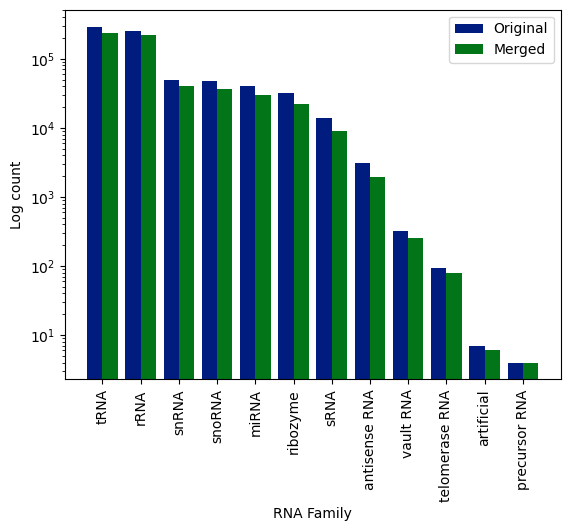

In [9]:
merge_sequence['RNA Class'], merge_sequence['RNA Family'] = contract_families(merge_sequence['RNA Type'])
# visual_comp_merged(rna, merge_sequence)
# visual_comp_merged(rna, merge_sequence, 'RNA Class')
visual_comp_merged(rna, merge_sequence, 'RNA Family')

Feature engineering below includes: sequence length, nucleic acid ratios (ratios of A:T:C:G), ...

In [10]:
merge_sequence['Sequence len'] = merge_sequence['Sequence'].str.len()

seq = merge_sequence.loc[:, 'Sequence']

def nucleic_acid_ratios(target):
    A = 0
    C = 0
    T = 0
    G = 0
    N = 0
    bad_vals = 0;
    for ch in target:
        if (ch == "A"):
            A += 1
        elif (ch == 'C'):
            C += 1;
        elif (ch == 'T'):
            T += 1;
        elif (ch == 'G'):
            G += 1;
        else:
            N += 1;


    seq_len = len(target)
    a_rat = A / seq_len
    c_rat = C / seq_len
    t_rat = T / seq_len
    g_rat = G / seq_len
    n_rat = N / seq_len
    
    return a_rat, c_rat, t_rat, g_rat, n_rat;



In [11]:
merge_sequence["A Ratio"] = 0
merge_sequence["C Ratio"] = 0
merge_sequence["T Ratio"] = 0
merge_sequence["G Ratio"] = 0
merge_sequence["N Ratio"] = 0


for i in range (len(seq)):
    a_rat, c_rat, t_rat, g_rat, n_rat = nucleic_acid_ratios(seq[i])
    merge_sequence.loc[i, "A Ratio"] = a_rat
    merge_sequence.loc[i, "C Ratio"] = c_rat
    merge_sequence.loc[i, "T Ratio"] = t_rat
    merge_sequence.loc[i, "G Ratio"] = g_rat
    merge_sequence.loc[i, "N Ratio"] = n_rat

merge_sequence.head()

,Sequence,RNA Type,RNA Class,RNA Family,Sequence len,A Ratio,C Ratio,T Ratio,G Ratio,N Ratio
0,AAAAAAAAAAAAAAAAAAAAAAAATCCCTTTTTTTTTTTTTTTTTT...,ribozyme,gene,ribozyme,168,0.363095,0.136905,0.404762,0.095238,0.0
1,AAAAAAAAAAAAAAAAAAAAAGAAATGCCCGATCTCATCTGAATTC...,rRNA,gene,rRNA,119,0.369748,0.159664,0.201681,0.268908,0.0
2,AAAAAAAAAAAAAAAAAAAAATACTGGGATCAGGCAGCCAGTGGGT...,snRNA,gene,snRNA,163,0.282209,0.226994,0.220859,0.269939,0.0
3,AAAAAAAAAAAAAAAAAAAAATACTGGGATCAGGCAGCCAGTGGGT...,snRNA,gene,snRNA,163,0.282209,0.226994,0.226994,0.263804,0.0
4,AAAAAAAAAAAAAAAGGACCATACTGGGATCAGCCAGCCAGTGGGT...,snRNA,gene,snRNA,163,0.257669,0.239264,0.226994,0.276074,0.0


In [12]:
x = merge_sequence.loc[:, ['Sequence len', 'A Ratio', 'C Ratio', 'T Ratio', 'G Ratio', 'N Ratio']]
y = merge_sequence.loc[:, 'RNA Family']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

x_train.head()

,Sequence len,A Ratio,C Ratio,T Ratio,G Ratio,N Ratio
143674,459,0.259259,0.226580,0.193900,0.320261,0.0
385944,73,0.232877,0.260274,0.205479,0.301370,0.0
390244,69,0.159420,0.260870,0.231884,0.347826,0.0
209460,114,0.254386,0.254386,0.210526,0.280702,0.0
352953,72,0.208333,0.291667,0.194444,0.305556,0.0


In [13]:
ridge = RidgeClassifier().fit(x_train, y_train)
ridge.score(x_train, y_train)

0.7085940121920066

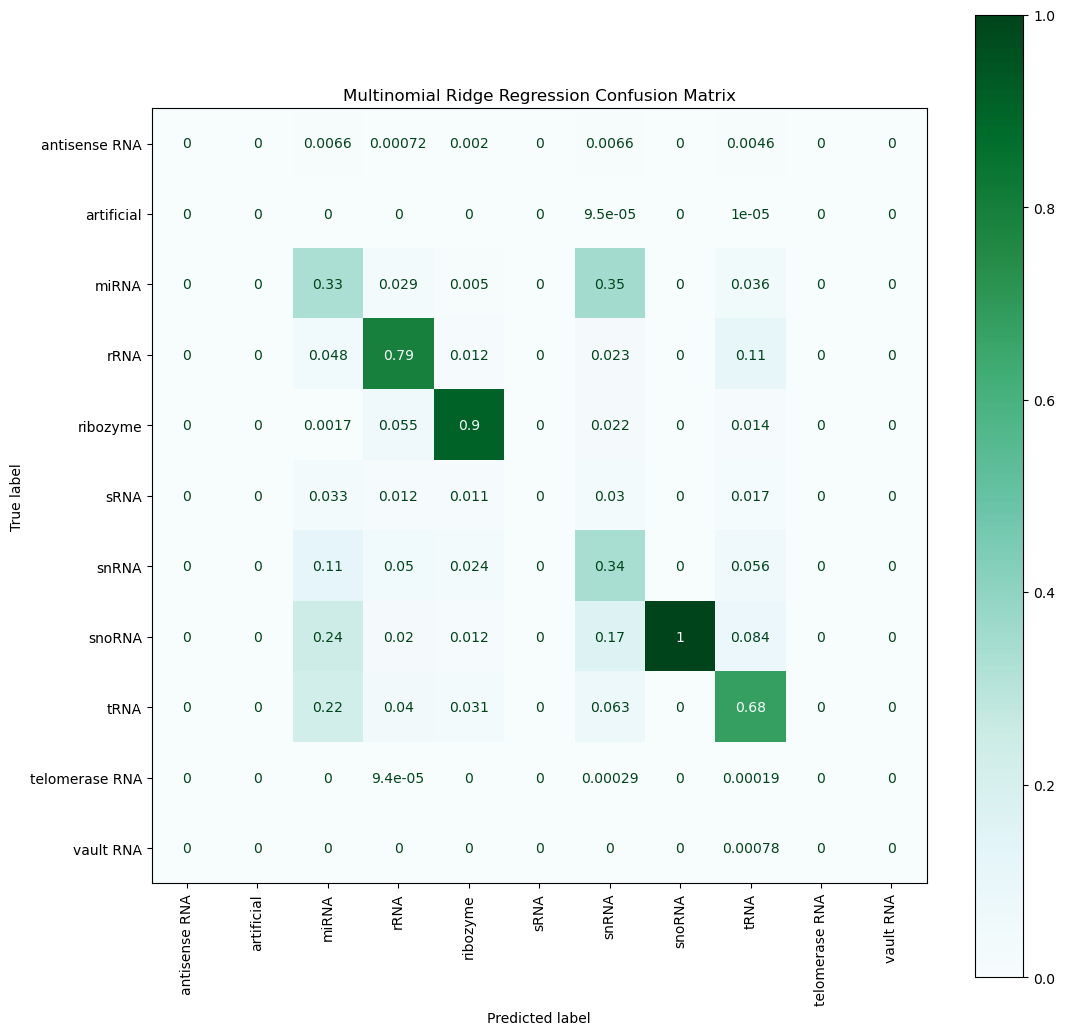

In [14]:
y_pred = ridge.predict(x_test)
fig, ax = plt.subplots(figsize=(12.5, 12.5))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='pred', ax=ax, xticks_rotation='vertical', cmap='BuGn')
plt.title('Multinomial Ridge Regression Confusion Matrix')
plt.show()

In [15]:
rfc = RandomForestClassifier().fit(x_train, y_train)
rfc.score(x_train, y_train)

0.9864780929577888

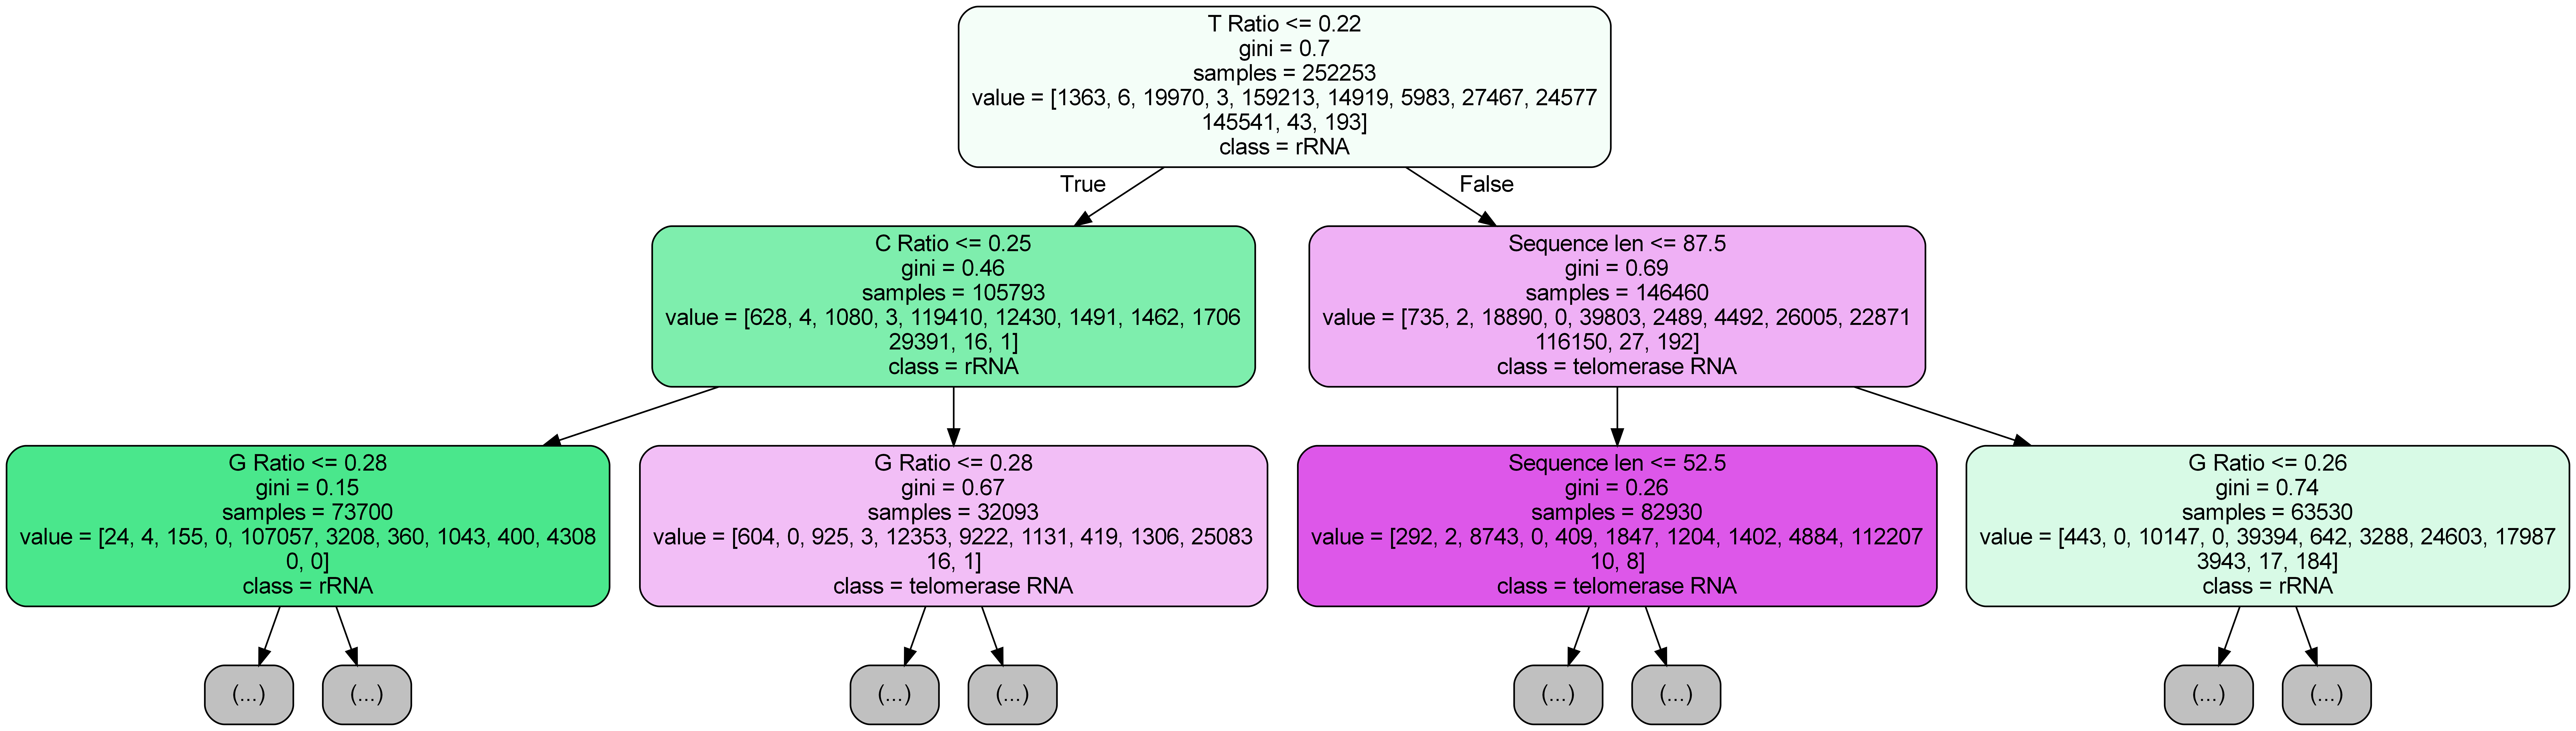

In [16]:
export_graphviz(rfc.estimators_[0], out_file='tree.dot', feature_names=list(x_train.columns), class_names=list(y_test.unique()), 
                rounded = True, proportion = False, precision = 2, filled = True, max_depth=2)
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
Image(filename = 'tree.png')

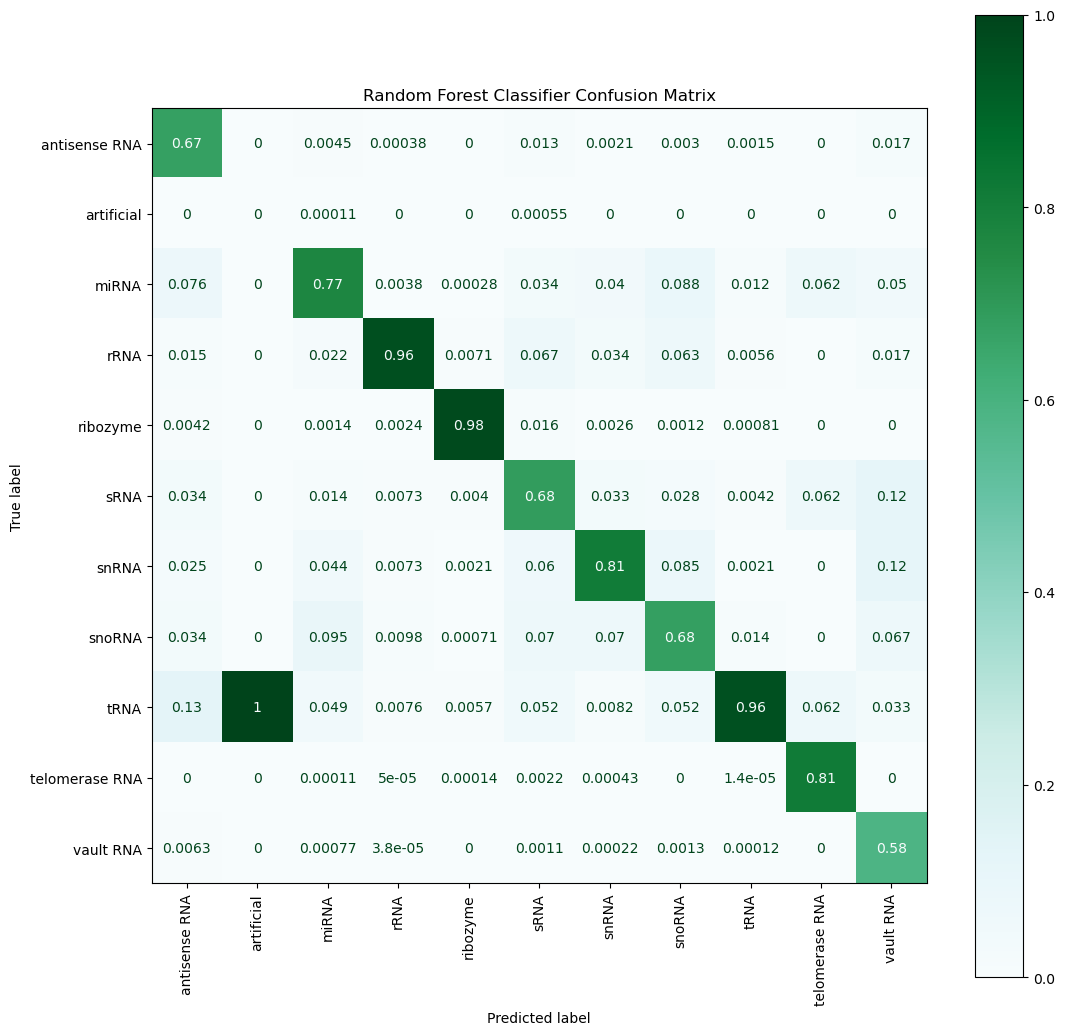

In [17]:
y_pred_rfc = rfc.predict(x_test)
fig, ax = plt.subplots(figsize=(12.5, 12.5))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rfc, normalize='pred', ax=ax, xticks_rotation='vertical', cmap='BuGn')
plt.title('Random Forest Classifier Confusion Matrix')
plt.show()

In [18]:
def multiclass_metrics(y_test, y_pred):
    prec = metrics.precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = metrics.recall_score(y_test, y_pred, average='weighted', zero_division=0)
    acc = metrics.balanced_accuracy_score(y_test, y_pred)
    
    print(f'Precision score: {prec}')
    print(f'Recall score: {rec}')
    print(f'Balanced accuracy score: {acc}')

In [19]:
print('Ridge classifier metrics:')
multiclass_metrics(y_test, y_pred)
print('\nRandom Forest classifier metrics:')
multiclass_metrics(y_test, y_pred_rfc)

Ridge classifier metrics:
Precision score: 0.6972580209127373
Recall score: 0.708801993287908
Balanced accuracy score: 0.20060123835499197

Random Forest classifier metrics:
Precision score: 0.9184584188445685
Recall score: 0.9208379945082884
Balanced accuracy score: 0.6307680361051654


P-value that the accuracy score of the Ridge Regression is by chance:  0.0099


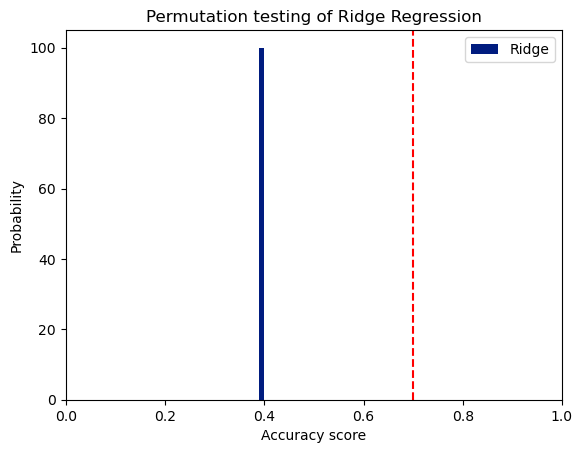

In [21]:
ridge_score, ridge_permutations, ridge_pval = permutation_test_score(ridge, x_test, y_test, n_permutations=100, n_jobs=-1, scoring='accuracy')
# rfc_score, rfc_permutations, rfc_pval = permutation_test_score(rfc, x_test, y_test, n_permutations=10, n_jobs=-1, scoring='accuracy')

plt.figure()
# plt.subplot(2, 1, 1)

plt.hist(ridge_permutations, label='Ridge', density=True, bins=100, range=(0, 1))

plt.title('Permutation testing of Ridge Regression')
plt.legend()
plt.xlim(0, 1)
plt.xlabel('Accuracy score')
plt.ylabel('Probability')
plt.axvline(ridge_score, color='r', linestyle='dashed')

# plt.subplot(2, 1, 2)

# plt.hist(rfc_permutations, label="Random Forest", bins=20)

# plt.legend()
# plt.xlim(0, 1)
# plt.xlabel('Accuracy score')
# plt.ylabel('Probability')
# plt.axvline(rfc_score, color='r', linestyle='dashed');
# plt.title('Permutation testing of Random Forest Model')

print(f'P-value that the accuracy score of the Ridge Regression is by chance: {ridge_pval: 0.4f}')
# print(f'P-value that the accuracy score of the Random Forest is by chance: {rfc_pval: 0.4f}')

In [22]:
def class_accuracies(cm, ks):
    
    per_class_accuracies = {}
    
    for idx, cls in enumerate(ks):
        true_negatives = np.sum(np.delete(np.delete(cm, idx, axis=0), idx, axis=1))

        true_positives = cm[idx, idx]

        per_class_accuracies[cls] = (true_positives + true_negatives) / np.sum(cm)
        
    return per_class_accuracies

P-value that the precision scores are drawn from the same distribution between models (Wilcoxon Ranked sums):  0.0660
P-value that the accuracy scores are drawn from the same distribution between models (Wilcoxon Ranked sums):  0.1783


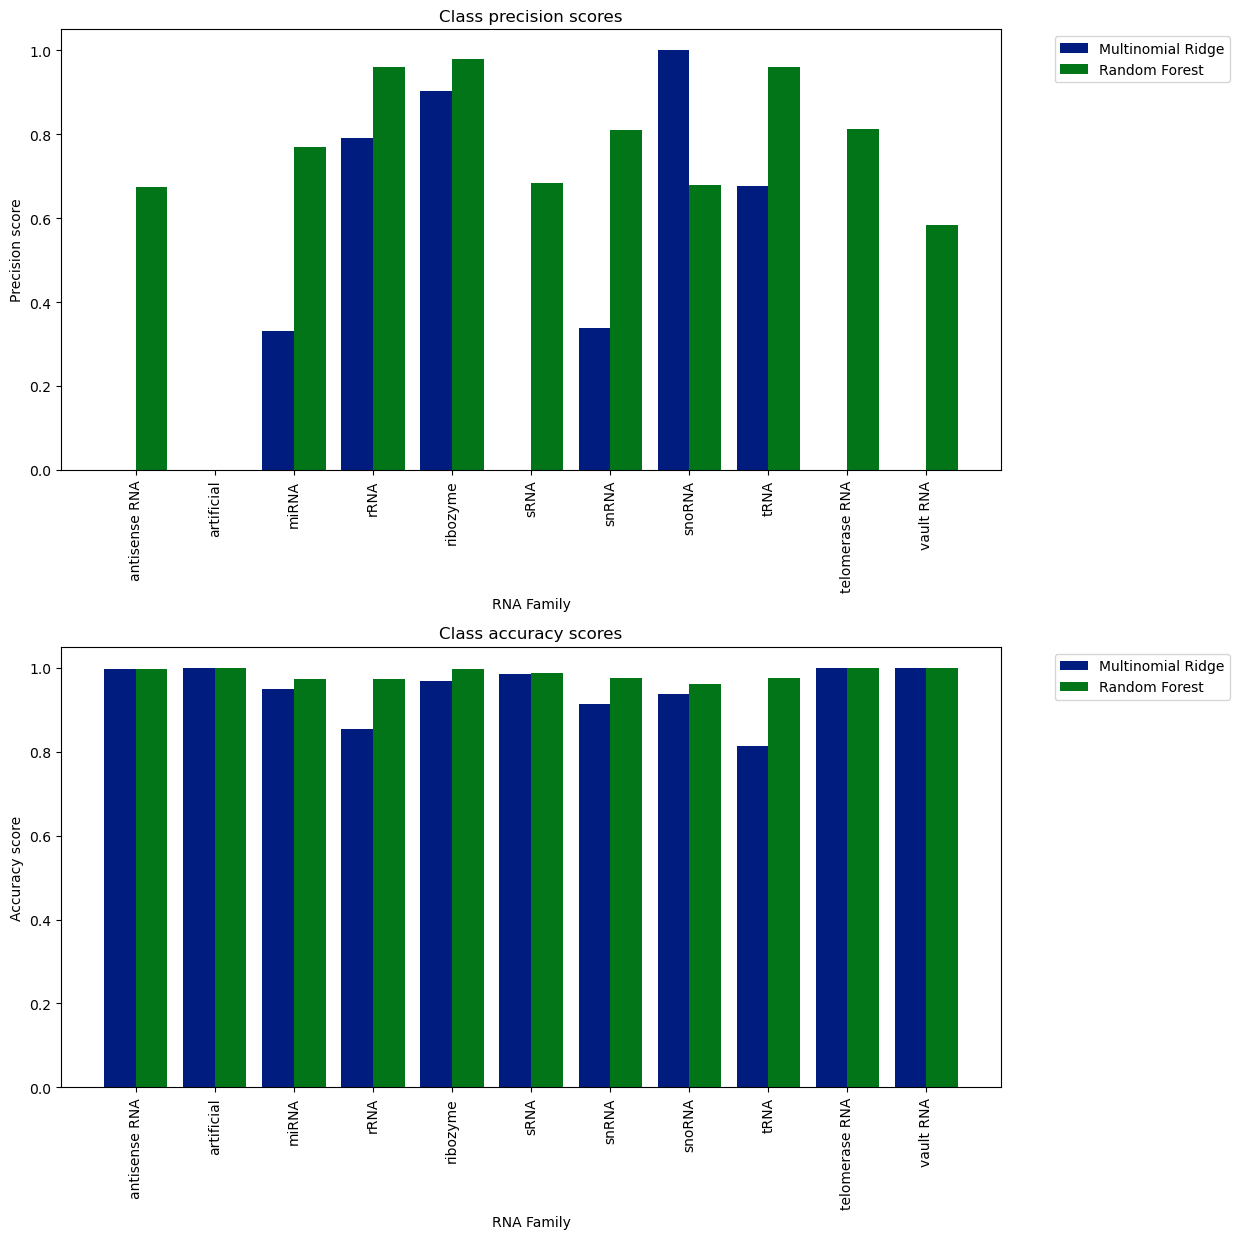

In [28]:
# metrics.multilabel_confusion_matrix(y_test, y_pred)
# metrics.multilabel_confusion_matrix(y_test, y_pred_rfc)
ridge_stats = metrics.classification_report(y_test, y_pred, zero_division=0, output_dict=True)
rfc_stats = metrics.classification_report(y_test, y_pred_rfc, zero_division=0, output_dict=True)


ridge_prec_sep = []
rfc_prec_sep = []

ks = list(rfc_stats.keys())
k = ks[0: ks.index('accuracy')]

for c in k:
    ridge_prec_sep.append(ridge_stats[c]['precision'])
    rfc_prec_sep.append(rfc_stats[c]['precision'])
    

xpos = np.arange(0, 2*len(k), 2)
    
plt.figure(figsize=[12.5, 12.5])
plt.subplot(2, 1, 1)
plt.bar(x=xpos, height=ridge_prec_sep, width=-0.8, align='edge', tick_label=k, label='Multinomial Ridge')
plt.bar(x=xpos, height=rfc_prec_sep, width=0.8, align='edge', label='Random Forest')

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xticks(rotation=90)
plt.ylabel('Precision score')
plt.xlabel('RNA Family')
plt.title('Class precision scores')
plt.tight_layout()


plt.subplot(2, 1, 2)

ridge_cm = metrics.confusion_matrix(y_test, y_pred)
rfc_cm = metrics.confusion_matrix(y_test, y_pred_rfc)

ridge_accs = class_accuracies(ridge_cm, k)
rfc_accs = class_accuracies(rfc_cm, k)

plt.bar(x=xpos, height=list(ridge_accs.values()), width=-0.8, align='edge', tick_label=k, label='Multinomial Ridge')
plt.bar(x=xpos, height=list(rfc_accs.values()), width=0.8, align='edge', label='Random Forest')

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xticks(rotation=90)
plt.ylabel('Accuracy score')
plt.xlabel('RNA Family')
plt.title('Class accuracy scores')
plt.tight_layout();

_, p_prec = ranksums(ridge_prec_sep, rfc_prec_sep)
_, p_accs = ranksums(list(ridge_accs.values()), list(rfc_accs.values()))

print(f'P-value that the precision scores are drawn from the same distribution between models (Wilcoxon Ranked sums): {p_prec: 0.4f}')
print(f'P-value that the accuracy scores are drawn from the same distribution between models (Wilcoxon Ranked sums): {p_accs: 0.4f}')

In [29]:
text = list(merge_sequence['Sequence'])
bigrams = ['AA', 'AT', 'AG', 'AC', 'TA', 'TT', 'TG', 'TC', 'GA', 'GT', 'GG', 'GC', 'CA', 'CT', 'CG', 'CC']
vec = CountVectorizer(ngram_range=(2,2), analyzer='char')
vec.fit(bigrams)
encode = vec.transform(text)
ngrams = pd.DataFrame(encode.A, columns=vec.get_feature_names_out())
merge_sequence = pd.concat([merge_sequence, ngrams], axis=1)

EIIP are the electron-ion interaction pseudopotentials of each nucelotide. This is the standard scalar representation of RNA sequences (using U val for T)

A = 0.1260, U = 0.1335, G =  0.0806, and C = 0.1340
Output dimensions of EIIP should be equal to the length of the original sequence

In [30]:
def chemical_encoding(target):
    template_seq = ''
    EIIP = 0
    for ch in target:
        if (ch == "A"):
            EIIP += (0.1260)
        elif (ch == 'C'):
            EIIP += (0.1340)
        elif (ch == 'T'):
            EIIP += (0.1335)
        elif (ch == 'G'):
            EIIP += (0.0806)
        else:
            EIIP += (0.0000)

            
    return EIIP/len(target);


merge_sequence['Average EIIP'] = merge_sequence.apply(lambda row : chemical_encoding(row['Sequence']), axis=1)
merge_sequence.head()

,Sequence,RNA Type,RNA Class,RNA Family,Sequence len,A Ratio,C Ratio,T Ratio,G Ratio,N Ratio,...,ct,ga,gc,gg,gt,ta,tc,tg,tt,Average EIIP
0,AAAAAAAAAAAAAAAAAAAAAAAATCCCTTTTTTTTTTTTTTTTTT...,ribozyme,gene,ribozyme,168,0.363095,0.136905,0.404762,0.095238,0.0,...,9,7,2,2,5,10,11,7,40,0.125807
1,AAAAAAAAAAAAAAAAAAAAAGAAATGCCCGATCTCATCTGAATTC...,rRNA,gene,rRNA,119,0.369748,0.159664,0.201681,0.268908,0.0,...,8,8,6,12,6,5,5,10,3,0.116582
2,AAAAAAAAAAAAAAAAAAAAATACTGGGATCAGGCAGCCAGTGGGT...,snRNA,gene,snRNA,163,0.282209,0.226994,0.220859,0.269939,0.0,...,9,5,12,18,9,8,8,10,9,0.117217
3,AAAAAAAAAAAAAAAAAAAAATACTGGGATCAGGCAGCCAGTGGGT...,snRNA,gene,snRNA,163,0.282209,0.226994,0.226994,0.263804,0.0,...,9,5,12,16,10,8,8,11,9,0.117542
4,AAAAAAAAAAAAAAAGGACCATACTGGGATCAGCCAGCCAGTGGGT...,snRNA,gene,snRNA,163,0.257669,0.239264,0.226994,0.276074,0.0,...,9,6,13,16,10,8,7,12,9,0.117083


In [31]:
x_extended = merge_sequence.loc[:, ['Sequence len', 'A Ratio', 'C Ratio', 'T Ratio', 'G Ratio', 'N Ratio', 'Average EIIP'] + 
                                list(vec.vocabulary_.keys())]

x_train_extended, x_test_extended, y_train, y_test = train_test_split(x_extended, y, test_size=0.33)

x_extended.head()

,Sequence len,A Ratio,C Ratio,T Ratio,G Ratio,N Ratio,Average EIIP,aa,at,ag,...,tg,tc,ga,gt,gg,gc,ca,ct,cg,cc
0,168,0.363095,0.136905,0.404762,0.095238,0.0,0.125807,37,14,3,...,7,11,7,5,2,2,6,9,4,4
1,119,0.369748,0.159664,0.201681,0.268908,0.0,0.116582,27,7,7,...,10,5,8,6,12,6,3,8,3,5
2,163,0.282209,0.226994,0.220859,0.269939,0.0,0.117217,24,9,7,...,10,8,5,9,18,12,8,9,9,11
3,163,0.282209,0.226994,0.226994,0.263804,0.0,0.117542,24,9,7,...,11,8,5,10,16,12,8,9,9,11
4,163,0.257669,0.239264,0.226994,0.276074,0.0,0.117083,18,9,8,...,12,7,6,10,16,13,9,9,9,12


0.7548049228858089


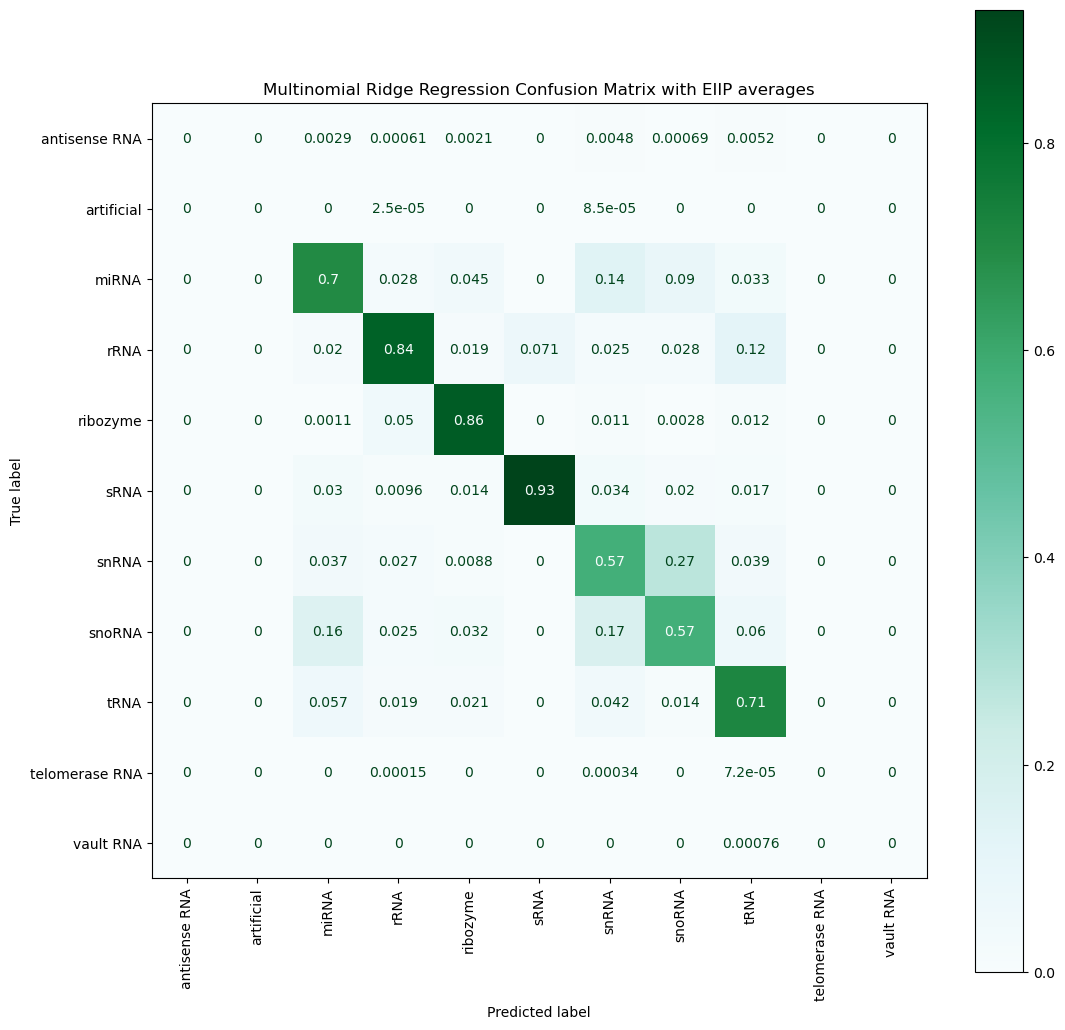

In [32]:
ridge_eiip = RidgeClassifier().fit(x_train_extended, y_train)
print(ridge_eiip.score(x_train_extended, y_train))

y_pred_eiip = ridge_eiip.predict(x_test_extended)
fig, ax = plt.subplots(figsize=(12.5, 12.5))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_eiip, normalize='pred', ax=ax, xticks_rotation='vertical', cmap='BuGn')
plt.title('Multinomial Ridge Regression Confusion Matrix with EIIP averages')
plt.show()

1.0


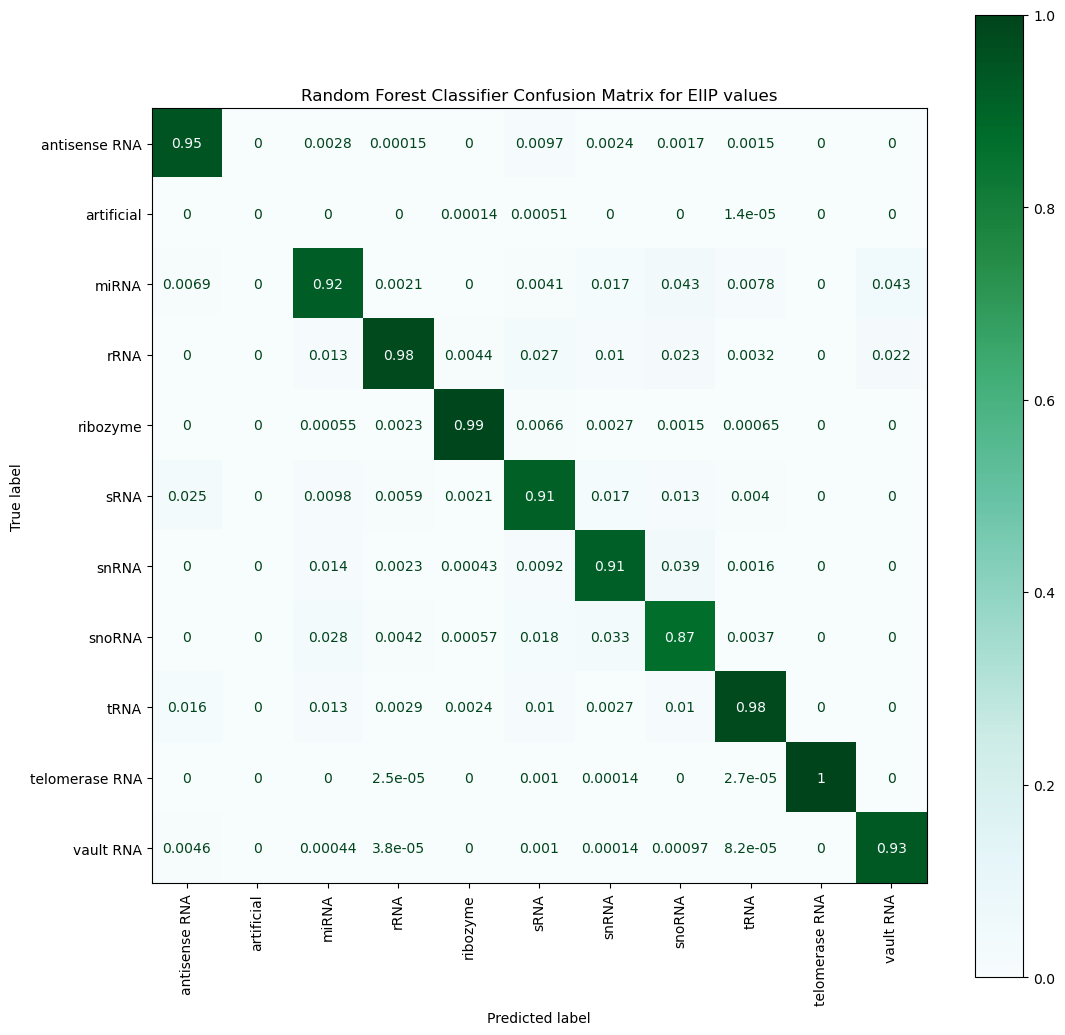

In [33]:
rfc_eiip = RandomForestClassifier().fit(x_train_extended, y_train)
print(rfc_eiip.score(x_train_extended, y_train))

y_pred_rfc_eiip = rfc_eiip.predict(x_test_extended)
fig, ax = plt.subplots(figsize=(12.5, 12.5))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rfc_eiip, normalize='pred', ax=ax, xticks_rotation='vertical', cmap='BuGn')
plt.title('Random Forest Classifier Confusion Matrix for EIIP values')
plt.show()

In [34]:
print('Ridge classifier metrics:')
multiclass_metrics(y_test, y_pred_eiip)
print('\nRandom Forest classifier metrics:')
multiclass_metrics(y_test, y_pred_rfc_eiip)

Ridge classifier metrics:
Precision score: 0.7500468410735819
Recall score: 0.7540831892606529
Balanced accuracy score: 0.27109533039909817

Random Forest classifier metrics:
Precision score: 0.9638232231670051
Recall score: 0.9642225160174921
Balanced accuracy score: 0.7342033756300125


P-value that the accuracy score of the Ridge Regression was by chance:  0.0099


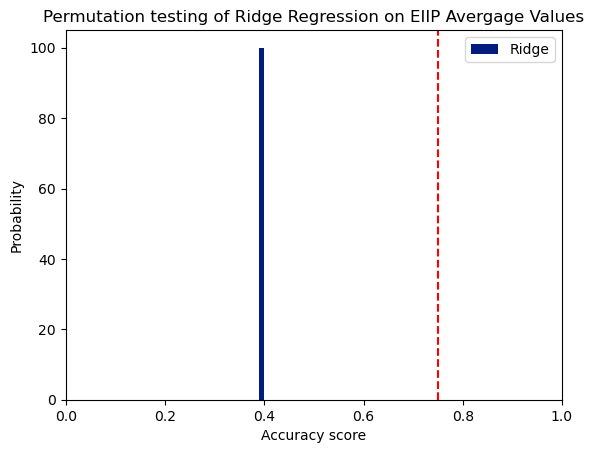

In [35]:
ridge_score_eiip, ridge_permutations_eiip, ridge_pval_eiip = permutation_test_score(ridge_eiip, x_test_extended, y_test, n_permutations=100, 
                                                                                    n_jobs=-1, scoring='accuracy')

plt.figure()

plt.hist(ridge_permutations_eiip, label='Ridge', density=True, bins=100, range=(0, 1))

plt.title('Permutation testing of Ridge Regression on EIIP Avergage Values')
plt.legend()
plt.xlim(0, 1)
plt.xlabel('Accuracy score')
plt.ylabel('Probability')
plt.axvline(ridge_score_eiip, color='r', linestyle='dashed')

print(f'P-value that the accuracy score of the Ridge Regression was by chance: {ridge_pval_eiip: 0.4f}')

P-value that the precision scores are drawn from the same distribution between models (Wilcoxon Ranked sums):  0.1396
P-value that the accuracy scores are drawn from the same distribution between models (Wilcoxon Ranked sums):  0.0762


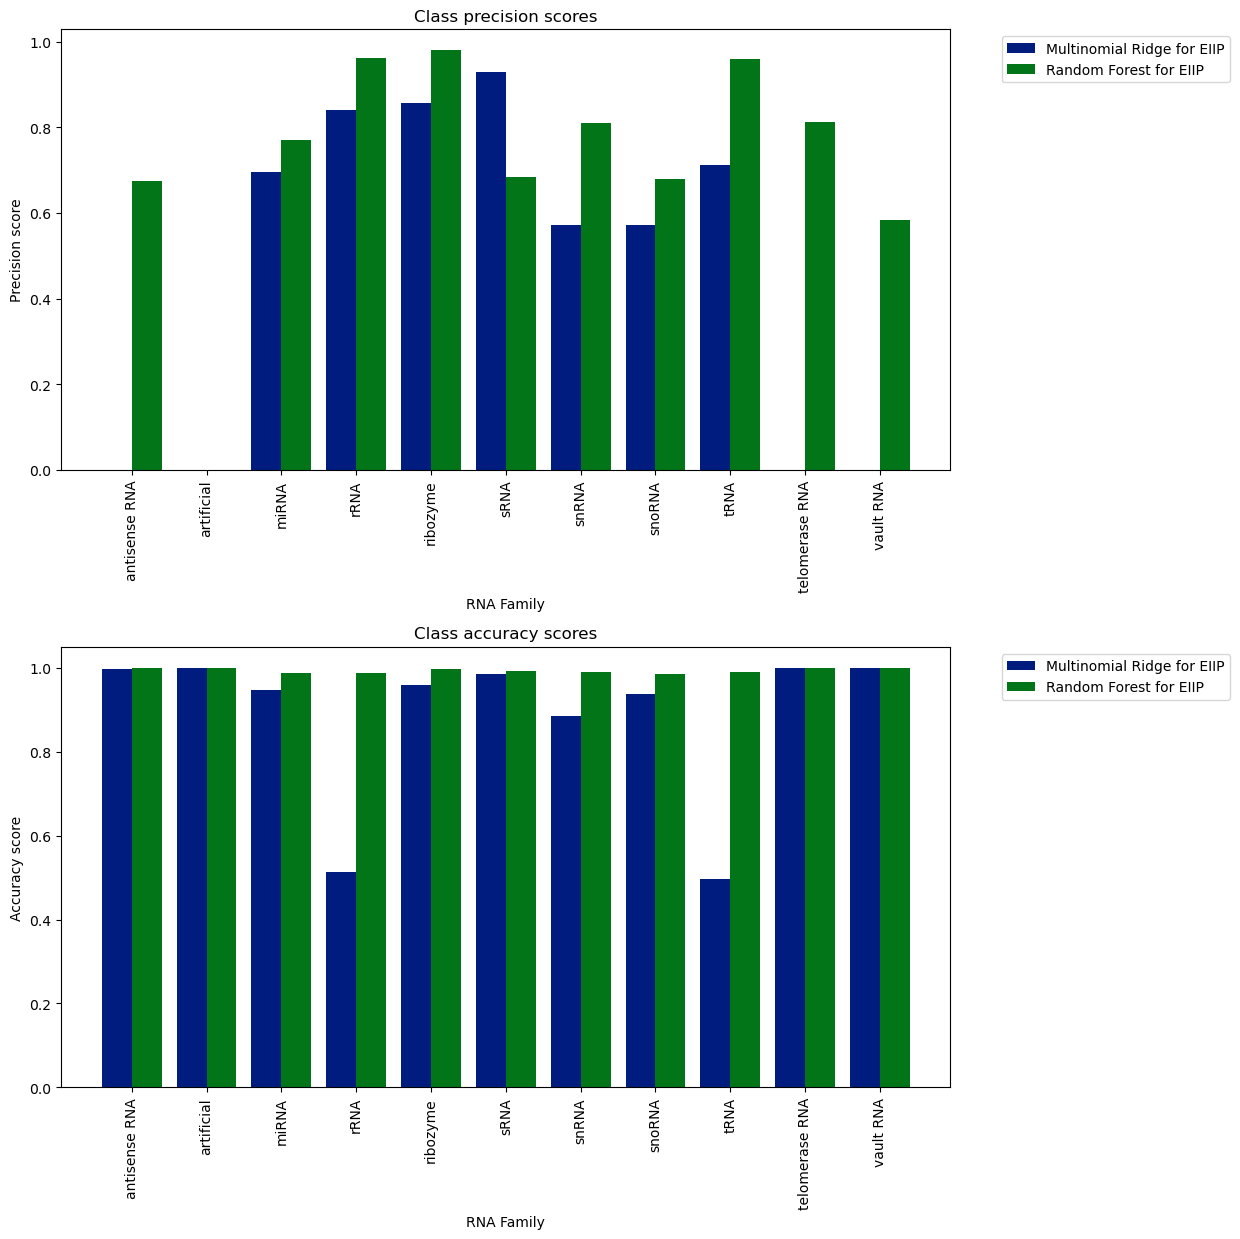

In [36]:
# metrics.multilabel_confusion_matrix(y_test, y_pred)
# metrics.multilabel_confusion_matrix(y_test, y_pred_rfc)
ridge_stats_eiip = metrics.classification_report(y_test, y_pred_eiip, zero_division=0, output_dict=True)
rfc_stats_eiip = metrics.classification_report(y_test, y_pred_rfc_eiip, zero_division=0, output_dict=True)


ridge_prec_sep_eiip = []
rfc_prec_sep_eiip = []

ks = list(ridge_stats_eiip.keys())
k = ks[0: ks.index('accuracy')]

for c in k:
    ridge_prec_sep_eiip.append(ridge_stats_eiip[c]['precision'])
    rfc_prec_sep_eiip.append(rfc_stats[c]['precision'])
    

xpos = np.arange(0, 2*len(k), 2)
    
plt.figure(figsize=[12.5, 12.5])
plt.subplot(2, 1, 1)
plt.bar(x=xpos, height=ridge_prec_sep_eiip, width=-0.8, align='edge', tick_label=k, label='Multinomial Ridge for EIIP')
plt.bar(x=xpos, height=rfc_prec_sep_eiip, width=0.8, align='edge', label='Random Forest for EIIP')

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xticks(rotation=90)
plt.ylabel('Precision score')
plt.xlabel('RNA Family')
plt.title('Class precision scores')
plt.tight_layout()


plt.subplot(2, 1, 2)

ridge_cm_eiip = metrics.confusion_matrix(y_test, y_pred)
rfc_cm_eiip = metrics.confusion_matrix(y_test, y_pred_rfc_eiip)

ridge_accs_eiip = class_accuracies(ridge_cm_eiip, k)
rfc_accs_eiip = class_accuracies(rfc_cm_eiip, k)

plt.bar(x=xpos, height=list(ridge_accs_eiip.values()), width=-0.8, align='edge', tick_label=k, label='Multinomial Ridge for EIIP')
plt.bar(x=xpos, height=list(rfc_accs_eiip.values()), width=0.8, align='edge', label='Random Forest for EIIP')

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xticks(rotation=90)
plt.ylabel('Accuracy score')
plt.xlabel('RNA Family')
plt.title('Class accuracy scores')
plt.tight_layout();

_, p_prec_eiip = ranksums(ridge_prec_sep_eiip, rfc_prec_sep_eiip)
_, p_accs_eiip = ranksums(list(ridge_accs_eiip.values()), list(rfc_accs_eiip.values()))

print(f'P-value that the precision scores are drawn from the same distribution between models (Wilcoxon Ranked sums): {p_prec_eiip: 0.4f}')
print(f'P-value that the accuracy scores are drawn from the same distribution between models (Wilcoxon Ranked sums): {p_accs_eiip: 0.4f}')

In [37]:
_, p_prec_vs_eiip = ranksums(rfc_prec_sep_eiip, rfc_prec_sep)
_, p_accs_vs_eiip = ranksums(list(rfc_accs.values()), list(rfc_accs_eiip.values()))


print('P-value that the precision scores are drawn from the same distribution between RFC models' +
      f'\n- before and after adding EIIP (Wilcoxon Ranked sums): {p_prec_vs_eiip: 0.4f}')
print('P-value that the accuracy scores are drawn from the same distribution between  RFC models' +
      f'\n- before and after adding EIIP (Wilcoxon Ranked sums): {p_accs_vs_eiip: 0.4f}')

P-value that the precision scores are drawn from the same distribution between RFC models
- before and after adding EIIP (Wilcoxon Ranked sums):  1.0000
P-value that the accuracy scores are drawn from the same distribution between  RFC models
- before and after adding EIIP (Wilcoxon Ranked sums):  0.1891


In [38]:
_, p_prec_vs_eiip = ranksums(ridge_prec_sep_eiip, ridge_prec_sep)
_, p_accs_vs_eiip = ranksums(list(ridge_accs.values()), list(ridge_accs_eiip.values()))

print('P-value that the precision scores are drawn from the same distribution between Ridge models' +
      f'\n- before and after adding EIIP (Wilcoxon Ranked sums): {p_prec_vs_eiip: 0.4f}')
print('P-value that the accuracy scores are drawn from the same distribution between Ridge models' + 
      f'\n- before and after adding EIIP (Wilcoxon Ranked sums): {p_accs_vs_eiip: 0.4f}')

P-value that the precision scores are drawn from the same distribution between Ridge models
- before and after adding EIIP (Wilcoxon Ranked sums):  0.6224
P-value that the accuracy scores are drawn from the same distribution between Ridge models
- before and after adding EIIP (Wilcoxon Ranked sums):  0.8182


In [39]:
etc = ExtraTreesClassifier().fit(x_train_extended, y_train)
print(etc.score(x_train_extended, y_train))

1.0


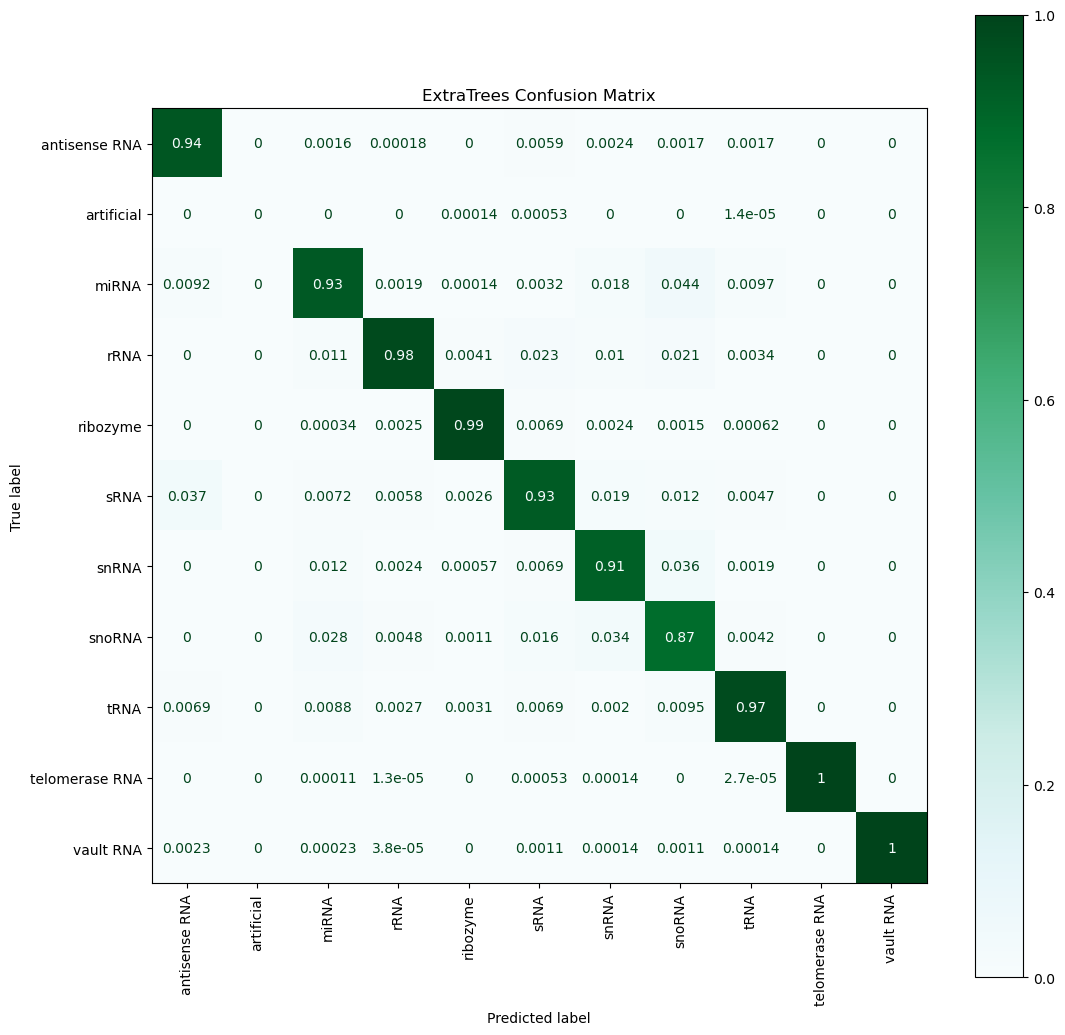

In [40]:
y_pred_etc = etc.predict(x_test_extended)
fig, ax = plt.subplots(figsize=(12.5, 12.5))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_etc, normalize='pred', ax=ax, xticks_rotation='vertical', cmap='BuGn')
plt.title('ExtraTrees Confusion Matrix')
plt.show()

In [41]:
print('ExtraTrees classifier metrics:')
multiclass_metrics(y_test, y_pred_etc)

ExtraTrees classifier metrics:
Precision score: 0.9631248546616374
Recall score: 0.9635004576426319
Balanced accuracy score: 0.7324998639166441
